# AED - Análise Exploratória de Dados das Abstenções Eleições 2022

## 1º Turno - Eleições 02/10/2022

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import geopandas as gpd
import numpy as np

from IPython.display import Image
from IPython.core.display import HTML 

from shapely.geometry import Polygon, LineString, Point

# IMPORTAÇÃO DOS DADOS
#### Fonte dos dados
> Foram utilizados dados extraídos diretamente dos órgãos oficiais responsáveis, sendo assim responsabilidade das instituições.

`perfil_comparecimento_abstencao_2022.csv `
> * https://dadosabertos.tse.jus.br/dataset/comparecimento-e-abstencao-2022.csv
> * última atualização: 25 de outubro de 2022, 13:27 (UTC-03:00)
> * *dataset* com as informações das abstenções das eleições, separadas por município

`evolucao_faltosos_ultimos_3_pleitos.csv`
> * https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/faltosos.csv
> * última atualização: 31 de outubro de 2022, 17:10 (UTC-03:00)
> * *dataset* com as informações do histórico das abstenções das eleições, desde 2005, extraído do site oficial do TSE.



`bcim_2016_21_11_2018.gpkg`
> * https://www.ibge.gov.br/geociencias/cartas-e-mapas/bases-cartograficas-continuas/15759-brasil.html?=&t=acesso-ao-produto
> * última atualização: 12 de novembro de 2022, 08:55 (UTC-03:00)
> * *informações geoespaciais* com todos os pontos de localizações dos municípios do Brasil, extraídos do site do IBGE.


In [2]:
# Carrega a base de dados de abstenção do 1ª turno das eleições 2022.
df = pd.read_csv('raw\perfil_comparecimento_abstencao_2022.zip', sep=';', encoding='latin1')

# Carrega a base de dados do histórico de abstenção do TSE desde 2005
df_tse = pd.read_csv('raw\evolucao_faltosos_ultimos_3_pleitos.csv', sep=';',encoding='latin1')

# Carrega o arquivo geoespacial disponibilizado pelo governo brasileiro com os pontos cardeais dos municípios
municipios = gpd.read_file('ibge-bcim/bcim_2016_21_11_2018.gpkg', layer = 'LIM_Municipio_A')
estados = gpd.read_file('ibge-bcim/bcim_2016_21_11_2018.gpkg', layer = 'LIM_Unidade_Federacao_A')

# Carrega arquivo com informações sobre áreas territoriais dos municipios
areas = pd.read_excel("raw\AR_BR_RG_UF_RGINT_RGIM_MES_MIC_MUN_2021.xls")

## Conhecendo os arquivos
#### Vamos começar com a base de abstenção do 1ª turno

In [3]:
df.head(3) # Mostra os 3 primeiros registros das abstenções de 2022

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,NR_TURNO,SG_UF,CD_MUNICIPIO,NM_MUNICIPIO,NR_ZONA,CD_GENERO,DS_GENERO,...,DS_FAIXA_ETARIA,CD_GRAU_ESCOLARIDADE,DS_GRAU_ESCOLARIDADE,QT_APTOS,QT_COMPARECIMENTO,QT_ABSTENCAO,QT_COMPARECIMENTO_DEFICIENCIA,QT_ABSTENCAO_DEFICIENCIA,QT_COMPARECIMENTO_TTE,QT_ABSTENCAO_TTE
0,14/10/2022,12:06:23,2022,1,AP,6009,PRACUÚBA,1,2,MASCULINO,...,40 a 44 anos,4,ENSINO FUNDAMENTAL COMPLETO,10,7,3,0,0,0,0
1,14/10/2022,12:06:23,2022,1,AP,6009,PRACUÚBA,1,2,MASCULINO,...,65 a 69 anos,4,ENSINO FUNDAMENTAL COMPLETO,2,2,0,0,0,0,0
2,14/10/2022,12:06:23,2022,1,AP,6009,PRACUÚBA,1,2,MASCULINO,...,75 a 79 anos,1,ANALFABETO,2,0,2,0,0,0,0


In [4]:
df.shape

(4392869, 23)

> Temos um total de 4.392.869 linhas e 23 colunas no arquivo de abstenções do TSE. Precisamos entender que tipo de arquivo de dados estamos trabalhando, o que representa cada linha do arquivo, já que conferindo na base do TSE diretamente no site o número de abstenções é de **aproximadamente 32,7M de abtenções** no 1º turno em 2022.

In [5]:
df.columns

Index(['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'NR_TURNO', 'SG_UF',
       'CD_MUNICIPIO', 'NM_MUNICIPIO', 'NR_ZONA', 'CD_GENERO', 'DS_GENERO',
       'CD_ESTADO_CIVIL', 'DS_ESTADO_CIVIL', 'CD_FAIXA_ETARIA',
       'DS_FAIXA_ETARIA', 'CD_GRAU_ESCOLARIDADE', 'DS_GRAU_ESCOLARIDADE',
       'QT_APTOS', 'QT_COMPARECIMENTO', 'QT_ABSTENCAO',
       'QT_COMPARECIMENTO_DEFICIENCIA', 'QT_ABSTENCAO_DEFICIENCIA',
       'QT_COMPARECIMENTO_TTE', 'QT_ABSTENCAO_TTE'],
      dtype='object')

> Este arquivo contém o leiaute das tabelas existentes no repositório de dados eleitorais


<table>
<thead>
	<tr>
		<th>Variável</th>
		<th>Descrição</th>
	</tr>
</thead>
<tbody>
	<tr>
		<td>DT_GERACAO</td>
		<td>Data da extração dos dados para geração do arquivo.
</td>
	</tr>
	<tr>
		<td>HH_GERACAO</td>
		<td>Hora da extração dos dados para geração do arquivo com
base no horário de Brasília.</td>
	</tr>
	<tr>
		<td>ANO_ELEICAO</td>
		<td>Ano de referência da eleição para geração do arquivo.
</td>
	</tr>
	<tr>
		<td>NR_TURNO</td>
		<td>Número do turno da eleição.</td>
	</tr>
	<tr>
		<td>SG_UF_ORIGEM</td>
		<td>Sigla da Unidade da Federação do domicílio eleitoral do
eleitor.</td>
	</tr>
	<tr>
		<td>CD_MUNICIPIO_ORIGEM</td>
		<td>Código do município do domicílio eleitoral do eleitor.</td>
	</tr>
	<tr>
		<td>NM_MUNICIPIO_ORIGEM</td>
		<td>Nome do município do domicílio eleitoral do eleitor.</td>
	</tr>
	<tr>
		<td>NR_ZONA_ORIGEM</td>
		<td>Número da zona eleitoral de votação do eleitor.</td>
	</tr>
	<tr>
		<td>SG_UF_DESTINO</td>
		<td>Sigla da Unidade da Federação de destino aonde o eleitor
que solicitou transferência temporária de eleitor (TTE)
votou.</td>
	</tr>
	<tr>
		<td>CD_MUNICIPIO_DESTINO</td>
		<td>Código TSE do município de destino aonde o eleitor que
solicitou transferência temporária de eleitor (TTE) votou.</td>
	</tr>
	<tr>
		<td>NM_MUNICIPIO_DESTINO</td>
		<td>Nome do município de destino aonde o eleitor que
solicitou transferência temporária de eleitor (TTE) votou.</td>
	</tr>
	<tr>
		<td>NR_ZONA_DESTINO</td>
		<td>Número da Zona Eleitoral de destino aonde o eleitor que
solicitou transferência temporária de eleitor (TTE) votou.</td>
	</tr>
	<tr>
		<td>CD_GENERO</td>
		<td>Código do gênero do eleitor. Valores possíveis: </br>
		2 -Masculino, </br>
		4 - Feminino e </br>
		0 - Não Informado.</td>
	</tr>
	<tr>
		<td>DS_GENERO</td>
		<td>Gênero do eleitor.</td>
	</tr>
	<tr>
		<td>CD_ESTADO_CIVIL</td>
		<td>Código do estado civil do eleitor de acordo com a última
atualização realizada pelo mesmo na Justiça Eleitoral.
Pode ocorrer de não representar o estado civil atual do
eleitor. Isso acontece quando o eleitor altera o estado civil,
porém não atualiza a informação junto à Justiça Eleitoral.</td>
	</tr>
	<tr>
		<td>DS_ESTADO_CIVIL</td>
		<td>Estado civil do eleitor de acordo com a última atualização
realizada pelo mesmo na Justiça Eleitoral. Pode ocorrer de
não representar o estado civil atual do eleitor. Isso
acontece quando o eleitor altera o estado civil, porém não
atualiza a informação junto à Justiça Eleitoral.</td>
	</tr>
	<tr>
		<td>CD_FAIXA_ETARIA</td>
		<td>Código da faixa etária a qual pertence o eleitor.</td>
	</tr>
	<tr>
		<td>DS_FAIXA_ETARIA</td>
		<td>Faixa etária a qual pertence o eleitor.</td>
	</tr>
	<tr>
		<td>CD_GRAU_ESCOLARIDADE</td>
		<td>Código do grau de escolaridade do eleitor de acordo com
a última atualização realizada pelo mesmo na Justiça
Eleitoral. Pode ocorrer de não representar o grau de
escolaridade atual do eleitor. Isso é justificado quando o
eleitor altera o grau de escolaridade, porém não atualiza a
informação junto à Justiça Eleitoral.</td>
	</tr>
	<tr>
		<td>DS_GRAU_ESCOLARIDADE</td>
		<td>Grau de escolaridade do eleitor de acordo com a última
atualização realizada pelo mesmo na Justiça Eleitoral.
Pode ocorrer de não representar o grau de escolaridade
atual do eleitor. Isso é justificado quando o eleitor altera o
grau de escolaridade, porém não atualiza a informação
junto à Justiça Eleitoral.</td>
	</tr>
	<tr>
		<td>CD_TIPO_TRANSFERENCIA</td>
		<td>Código do tipo de transferência temporária de eleitor.
Pode assumir os valores:
1 - Voto em trânsito;
2 - Preso provisório;
3 - Militar em serviço;
4 - Acessibilidade;
5 - Eleitor convocado;
6 - Justiça Eleitoral;
7 - TTE de Oficio;
8 - Indígenas/ Quilombolas.</td>
	</tr>
	<tr>
		<td>DS_TIPO_TRANSFERENCIA</td>
		<td>Tipo de transferência temporária de eleitor.</td>
	</tr>
	<tr>
		<td>QT_APTOS_EM_TTE</td>
		<td>Quantidade de eleitores aptos a votar naquele município e
zona no ano eleitoral que solicitaram transferência
temporária de eleitor (TTE). É possível que o mesmo
eleitor esteja em mais de um tipo de transferência. Isso
ocorre nos casos em que um eleitor faz o requerimento de
voto em trânsito e o TRE faz requerimento de ofício. Como
o arquivo é detalhado por tipo de transferência, o mesmo
eleitor pode aparecer nos dois tipos de transferência.</td>
	</tr>
	<tr>
		<td>QT_COMPARECIMENTO_TTE</td>
		<td>Quantidade de eleitores aptos que compareceram às
eleições naquele município e zona que solicitaram
transferência temporária de eleitor (TTE). É possível
que o mesmo eleitor esteja em mais de um tipo de
transferência. Isso ocorre nos casos em que um eleitor faz
o requerimento de voto em trânsito e o TRE faz
requerimento de ofício. Como o arquivo é detalhado por
tipo de transferência, o mesmo eleitor pode aparecer nos
dois tipos de transferência.</td>
	</tr>
	<tr>
		<td>QT_ABSTENCAO_TTE</td>
		<td>Quantidade de eleitores aptos que não compareceram às
eleições naquele município e zona que solicitaram
transferência temporária de eleitor (TTE). É possível
que o mesmo eleitor esteja em mais de um tipo de
transferência. Isso ocorre nos casos em que um eleitor faz
o requerimento de voto em trânsito e o TRE faz
requerimento de ofício. Como o arquivo é detalhado por
tipo de transferência, o mesmo eleitor pode aparecer nos
dois tipos de transferência.</td>
	</tr>
</tbody>
</table>



In [6]:
df.describe()

,ANO_ELEICAO,NR_TURNO,CD_MUNICIPIO,NR_ZONA,CD_GENERO,CD_ESTADO_CIVIL,CD_FAIXA_ETARIA,CD_GRAU_ESCOLARIDADE,QT_APTOS,QT_COMPARECIMENTO,QT_ABSTENCAO,QT_COMPARECIMENTO_DEFICIENCIA,QT_ABSTENCAO_DEFICIENCIA,QT_COMPARECIMENTO_TTE,QT_ABSTENCAO_TTE
count,4392869.0,4392869.0,4.392869e+06,4.392869e+06,4.392869e+06,4.392869e+06,4.392869e+06,4.392869e+06,4.392869e+06,4.392869e+06,4.392869e+06,4.392869e+06,4.392869e+06,4.392869e+06,4.392869e+06
mean,2022.0,1.0,5.187061e+04,9.825806e+01,3.043434e+00,3.845770e+00,5.314770e+03,4.291120e+00,3.561545e+01,2.816776e+01,7.447693e+00,1.868203e-01,1.025990e-01,1.374992e-01,1.434097e-02
std,0.0,0.0,2.843454e+04,9.187214e+01,1.017736e+00,2.843085e+00,2.150650e+03,2.213218e+00,1.264771e+02,1.050238e+02,2.535304e+01,1.206875e+00,6.503269e-01,1.132758e+00,2.064155e-01
min,2022.0,1.0,1.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,-3.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2022.0,1.0,2.633600e+04,2.900000e+01,2.000000e+00,1.000000e+00,3.539000e+03,2.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2022.0,1.0,5.441000e+04,6.900000e+01,4.000000e+00,3.000000e+00,5.559000e+03,4.000000e+00,5.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2022.0,1.0,7.585000e+04,1.400000e+02,4.000000e+00,5.000000e+00,7.074000e+03,6.000000e+00,2.000000e+01,1.500000e+01,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2022.0,1.0,9.947300e+04,4.270000e+02,4.000000e+00,9.000000e+00,9.999000e+03,8.000000e+00,7.187000e+03,5.443000e+03,1.744000e+03,2.720000e+02,1.460000e+02,3.650000e+02,7.000000e+01


> Entendemos que o arquivo contém dados de **4.392.869 linhas**, separados por informações únicas dos municípior. O arquivo consolida o número de abstenções separados por faixa etária, grau de escolaridade, estado civil, etc.
> Precisamos mais a frente fazer um cálculo somando todas abstenções para descobrir a quantidade total de eleitores que de fato se abstiveram, chegando no número que o TSE divulgou de **32,7M de eleitores faltosos**. Dessa forma teremos certeza que estamos trabalhando com a base efetiva.

#### Agora vamos conhecer a base do histórico do TSE

In [7]:
df_tse.head(3)

,Ano,Abrangência,Eleitores(E),Identificados(I),%I/E,Regularizados(R),%R/I,Cancelados(C),%C/I,Cancelamento | Posterior(CP),Não sujeito ao cancelamento
0,2005,Brasil,121332279,1124366,"0,93",34704,"3,09",1081727,"96,21",7935,0
1,2005,Exterior,59352,0,0,0,0,0,0,0,0
2,2006,Brasil,122042825,614646,"0,5",28625,"4,66",569899,"92,72",16122,0


In [8]:
df_tse.shape

(18, 11)

> Temos um total de 18 linhas e 11 colunas no arquivo de histórico do TSE

In [9]:
df_tse.describe()

,Ano,Eleitores(E),Identificados(I),Regularizados(R),Cancelados(C),Cancelamento | Posterior(CP),Não sujeito ao cancelamento
count,18.000000,1.800000e+01,1.800000e+01,18.000000,1.800000e+01,18.000000,18.000000
mean,2011.333333,6.739236e+07,7.553354e+05,46602.944444,7.026500e+05,3598.055556,2293.444444
std,4.850713,6.945084e+07,8.820564e+05,68925.618520,8.198247e+05,4761.962948,7579.199346
min,2005.000000,5.935200e+04,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,2007.000000,2.133890e+05,1.466750e+03,84.750000,1.380250e+03,1.000000,0.000000
50%,2011.000000,6.091650e+07,3.298885e+05,15369.500000,3.131280e+05,978.000000,0.000000
75%,2015.000000,1.343210e+08,1.501258e+06,66121.250000,1.376575e+06,5508.000000,75.750000
max,2019.000000,1.468055e+08,2.568836e+06,244028.000000,2.411788e+06,16122.000000,31495.000000


> Entendemos que o arquivo possui o histórico anual de **faltosos entre 2005 e 2019**, separados por regularizados e ou cancelados.

#### Vamos olhar o arquivo de estados

In [10]:
estados.head(3)

,nome,nomeabrev,geometriaaproximada,sigla,geocodigo,id_produtor,id_elementoprodutor,cd_insumo_orgao,nr_insumo_mes,nr_insumo_ano,tx_insumo_documento,geometry
0,Goiás,None,Sim,GO,52,1000001,None,NaN,None,None,None,"MULTIPOLYGON (((-50.15876 -12.41581, -50.15743..."
1,Mato Grosso do Sul,None,Sim,MS,50,1000001,None,NaN,None,None,None,"MULTIPOLYGON (((-56.09815 -17.17220, -56.09159..."
2,Paraná,None,Sim,PR,41,1000001,None,NaN,None,None,None,"MULTIPOLYGON (((-52.08090 -22.52893, -52.04903..."


> Essa é a base do IBGE que contém o mapeamento geoespacial das bases cartográficas do Brasil, com os pontos de latitude e longitude para plotagem de mapas.

## Correções e alterações
### Nessa parte é importante fazer a limpeza e preparação dos dados

In [11]:
# Renomear os campos para fazer o merge entre os df para pegar latitude e longitude dos estados.
estados.rename(columns={'sigla': 'SG_UF'}, inplace=True)

# Renomear os campos para fazer o merge entre os df para pegar latitude e longitude das cidades.
municipios.rename(columns={'nome': 'NM_MUNICIPIO'}, inplace=True)

# Corrigimos os nomes para minúsculos para cruzarmos as bases
municipios['NM_MUNICIPIO'] = municipios['NM_MUNICIPIO'].str.lower() \
                             .str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

df['NM_MUNICIPIO'] = df['NM_MUNICIPIO'].str.lower() \
                     .str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

# Conferimos que a base continua com o mesmo tamanho
print(f"Temos um total de {df.shape} linhas e colunas")

Temos um total de (4392869, 23) linhas e colunas


In [12]:
# Fazemos o merge entre a base de abstenção e de municípios.
df = df.merge(estados, on = 'SG_UF', how = 'left')

# Conferimos que a base continua com o mesmo tamanho
print(f"Continuamos com um total de {df.shape} linhas e colunas, mantendo o mesmo número após o segundo cruzamento")

Continuamos com um total de (4392869, 34) linhas e colunas, mantendo o mesmo número após o segundo cruzamento


> Conferimos que o cruzamento entre as bases deu certo, então agora temos a base das abstenções com os pontos de latitude e longitude. Com isso podemos continuar a preparação dos dados e começar a pensar na nossa análise.

In [13]:
# Agrupamos o dataframe por UF somando a quantidade de abstenções,
# pois identificamos que o arquivo está separado por faixa etária, genero, grau de escolaridade, etc.

# Dessa forma teremos uma linha por UF com o total de abstenções
# Vamos apresentar os dados por milhão, para facilitar a visualização

df_uf = df.groupby(['SG_UF'], as_index=False)['QT_ABSTENCAO'].sum().sort_values(by='QT_ABSTENCAO',  ascending=False)
df_uf['QT_ABSTENCAO'] = (df_uf['QT_ABSTENCAO'] / 1000000).round(2)

df_uf

,SG_UF,QT_ABSTENCAO
25,SP,7.49
10,MG,3.63
18,RJ,2.92
4,BA,2.41
22,RS,1.70
17,PR,1.65
13,PA,1.29
15,PE,1.28
5,CE,1.19
9,MA,1.12


#### Quantos milhões de brasileiros faltaram?
> Para responder essa pergunta nós precisamos agrupar os dados por estado

In [14]:
# Fazemos um merge entre o df que criamos com a soma das abstenções entre os estados, 
# e a base do IBGE, para conseguir os pontos geoespaciais para plotar o gráfico

df_uf = pd.merge(df_uf,estados[['SG_UF','geometry']],on='SG_UF', how='left')
df_uf = df_uf.dropna()

#### Preparando o gráfico

In [15]:
# Aqui nós separamos a base de dados e criamos o objeto do Geopandas
populacao_brasil = df_uf[['SG_UF','QT_ABSTENCAO','geometry']]
gdf_populacao = gpd.GeoDataFrame(populacao_brasil, geometry='geometry')

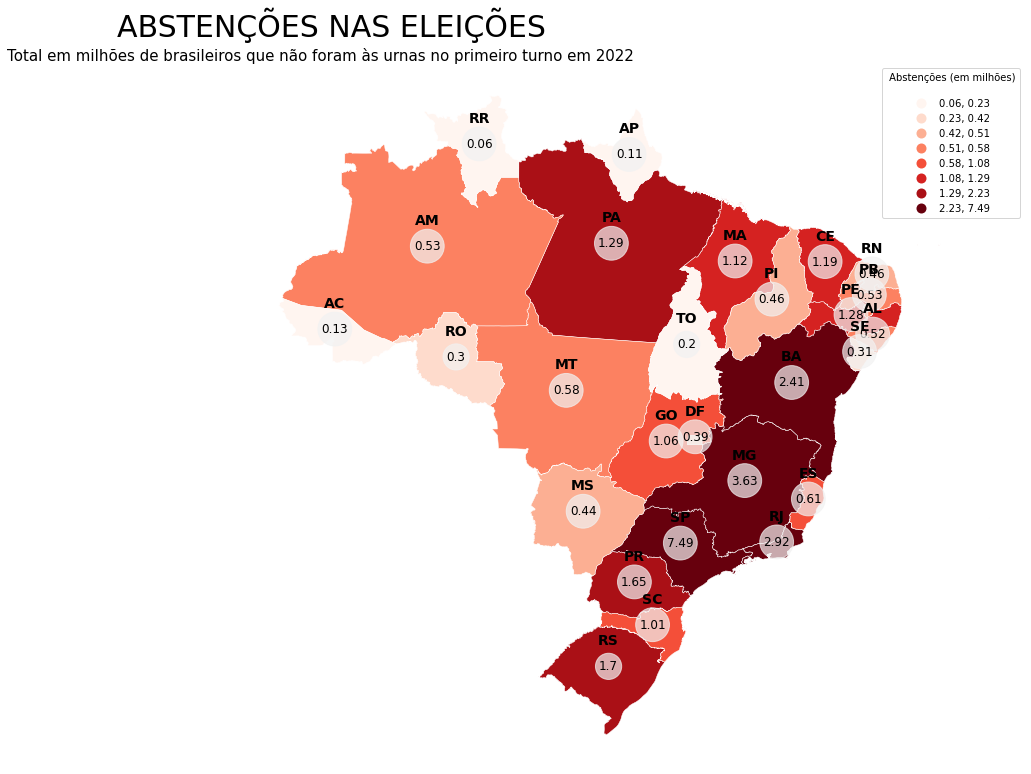

In [16]:
# Montamos a figura e plotamos o mapa com o matplotlib
fig, ax = plt.subplots(figsize=(14, 14), 
                       subplot_kw=dict(aspect='equal'))
plt.gcf().text(0, .89, "ABSTENÇÕES NAS ELEIÇÕES", fontsize = 30, color='Black' ,ha='left', va='center')
plt.title("Total em milhões de brasileiros que não foram às urnas no primeiro turno em 2022", fontsize = 15, ha='right', va='center')

gdf_populacao.plot(column='QT_ABSTENCAO', 
                   scheme='Quantiles', 
                   k=8, 
                   cmap='Reds', 
                   edgecolor='white',
                   linewidth=.5,
                   legend=True, 
                   ax=ax,
                  )

ax.get_legend().set_title(" Abstenções (em milhões)\n")

gdf_populacao.apply(lambda x: ax.annotate(text=x['QT_ABSTENCAO'], xy=x.geometry.centroid.coords[0], 
                                          ha='center', 
                                          fontsize = 12, 
                                          bbox=dict(boxstyle="Circle",
                                                   alpha=0.7,
                                                   ec=(0.94902, 0.94902, 0.94902),
                                                   fc=(0.94902, 0.94902, 0.94902),
                                                   )), 
                                          axis=1
                                           
                   )
gdf_populacao.apply(lambda x: ax.annotate(text=x.SG_UF, xy=x.geometry.centroid.coords[0], xytext=(0,25), textcoords='offset pixels', fontsize = 14, ha='center', color = "black", weight='semibold'), axis=1)
plt.axis('off')
plt.show()


# VISÃO GERAL

In [17]:
# Calcular o total de abstenções gerais
total_abstencao = df['QT_ABSTENCAO'].sum()
print(f"Temos um total de {total_abstencao} absteções.")

Temos um total de 32716740 absteções.


> Somando todas as linhas temos um total de **32.716.740 abstenções** no primeiro turno em 2022. Esse número equivale ao número TOTAL de eleitores que faltaram e não compareceram às urnas e equivale com a base apresentada pelo TSE no resultado das eleições.

> Dessa forma temos a quantidade total de eleitores que faltaram, juntamente dos pontos geospaciais de cada UF.

## APTOS VS ABSTENÇÕES

In [18]:
# Preparação dos dados para o gráfico

aux = df.groupby(['DT_GERACAO'], as_index=False)['QT_APTOS'].sum().sort_values(by='QT_APTOS',  ascending=False)
total_aptos = aux['QT_APTOS'].sum()

# Setando os 2 eixos para o gráfico
eixo_x = ['Total Aptos', 'Total Abstenção']
eixo_y = [total_aptos, total_abstencao]

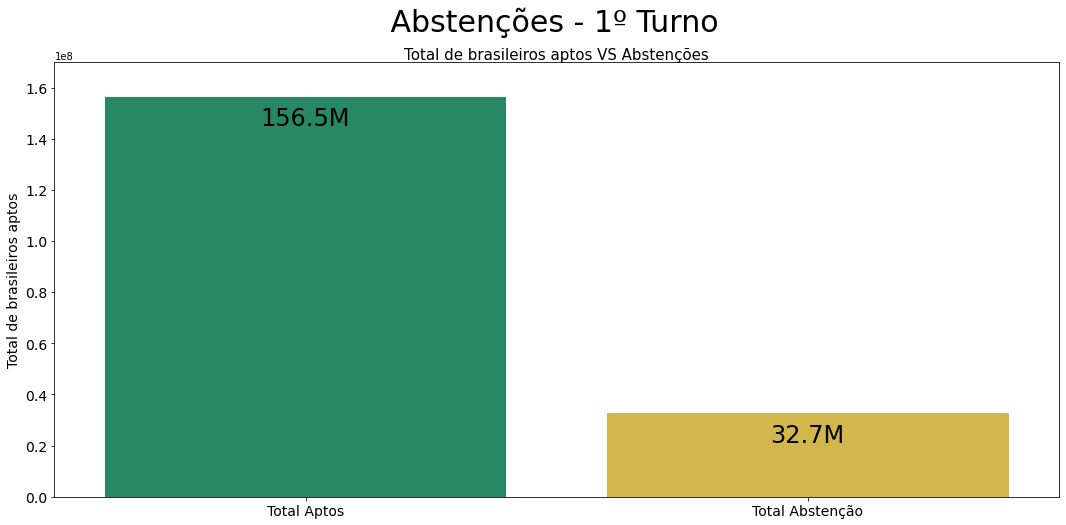

In [19]:
# Montando o setup e plotando o gráfico
cores = ["#eac435","#f4e21a","#ffff00","#dee92c","#afd62b","#87c141","#5fad56","#2f9f62","#189868","#00916e"]

fig = plt.figure(figsize=(18,8))
plot = sns.barplot(x=eixo_x,y=eixo_y, palette=["#189868","#eac435"])
plt.gcf().text(.5, .95, "   Abstenções - 1º Turno", fontsize = 30, color='Black' ,ha='center', va='center')
plt.title("Total de brasileiros aptos VS Abstenções", fontsize = 15, ha='center', va='center')
plt.ylabel("Total de brasileiros aptos", size = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plot.set(ylim = (0,170000000))       


for i in plot.patches:
    plot.annotate("{:.1f}M".format(i.get_height()/1000000),
                  (i.get_x() + i.get_width() / 2, i.get_height()),
                  ha='center', va='top', fontsize='24',
                  color='black', xytext=(0,-10),
                  textcoords='offset points')     
    
plt.show()    

#### Contagem
> No 1º turno tivemos um total de **156.454.011** de brasileiros aptos a votar, porém a cada eleição que passa o número de abstenções aumenta e passa a representar muito mais que a eleição de alguns candidatos menos expressivos.

> Em 2022 o número total de abstenções foi de **32.716.740** no 1º turno.

# QUANTO VALE 32 MILHÕES DE ABSTENÇÕES?

> Com mais de **20% dos eleitores não comparecendo** às eleições, começamos a pensar no papel importante que essas pessoas possuem no impacto da escolha de um candidato. 

In [20]:
abstencao_perc = total_abstencao / total_aptos
aptos_perc = 1 - abstencao_perc

perc = [abstencao_perc, aptos_perc]
legenda_perc = ['Abstenções', 'Compareceram']

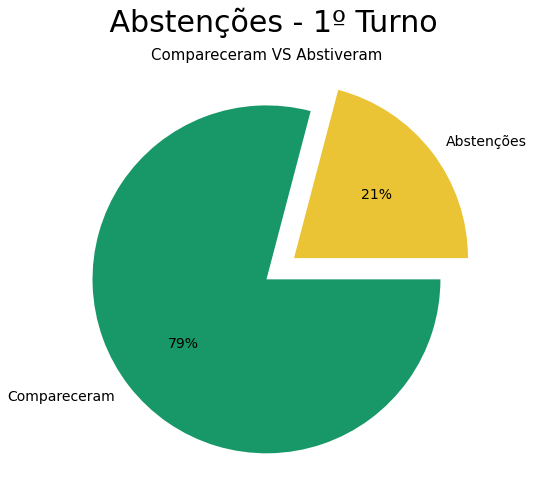

In [21]:
figura = plt.figure(figsize=(8,8))

plt.pie(perc, 
        labels = legenda_perc, 
        explode = [0.2, 0],
        autopct='%1.f%%', 
        textprops={'fontsize': 14},
        colors=["#eac435", "#189868"])
plt.gcf().text(.5, .95, "   Abstenções - 1º Turno", fontsize = 30, color='Black' ,ha='center', va='center')
plt.title("Compareceram VS Abstiveram", fontsize = 15, ha='center', va='center')
plt.show()

In [22]:
Image(url= "img/32milhoes.png") 


#### Histórico de abstenções
> Midiaticamente nos é colocado que o número de abstenções cresce a cada eleição, portanto é necessário confrontar com os dados oficiais do TSE. Baixamos a base que consta todas as abstenções nas eleições desde 2005, base mais antiga disponível no portal da transparência.

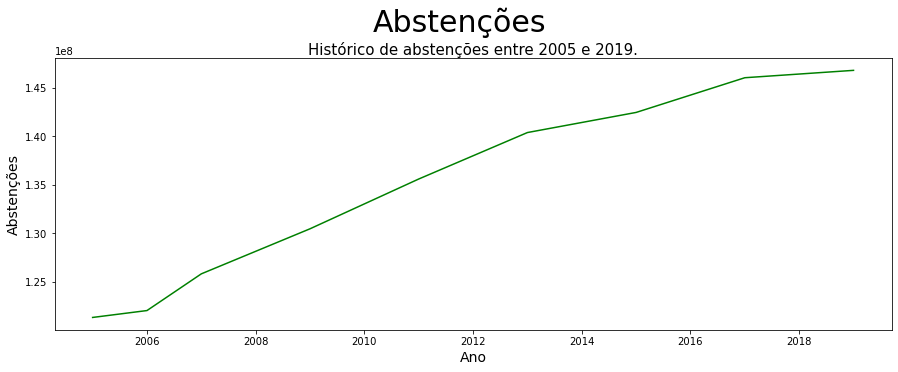

In [23]:
df_tse_brasil = df_tse.loc[(df_tse['Abrangência'] == 'Brasil')]

eixo_x = df_tse_brasil["Ano"]
eixo_y = df_tse_brasil["Eleitores(E)"]

figura = plt.figure(figsize=(15,5))
plt.gcf().text(.5, 0.98, "Abstenções", fontsize = 30, color='Black' ,ha='center', va='center')

plt.title("Histórico de abstenções entre 2005 e 2019.", fontsize = 15, ha='center', va='center')
plt.plot(eixo_x, eixo_y,'#008000')
plt.xlabel("Ano", size = 14)
plt.ylabel("Abstenções", size = 14)

plt.show()

#### Confirmação
> Podemos confirmar que de fato houve um aumento significativo nos últimos anos.

# ANÁLISE POR ESTADOS

In [24]:
# Agrupando e somando as abstenções por estado
agrupado_UF = df.groupby(['SG_UF'], as_index=False)['QT_ABSTENCAO'].sum().sort_values(by='QT_ABSTENCAO',  ascending=False)
agrupado_UF['perc'] = agrupado_UF['QT_ABSTENCAO'] / agrupado_UF['QT_ABSTENCAO'].sum()
# agrupado_UF = df.groupby('SG_UF').agg({'QT_ABSTENCAO':'sum'}, as_index=False).sort_values(by='QT_ABSTENCAO',  ascending=False)

In [25]:
# Setando os 2 eixos para o gráfico
eixo_x = agrupado_UF['SG_UF'].head(10)
eixo_y = agrupado_UF['QT_ABSTENCAO'].head(10)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


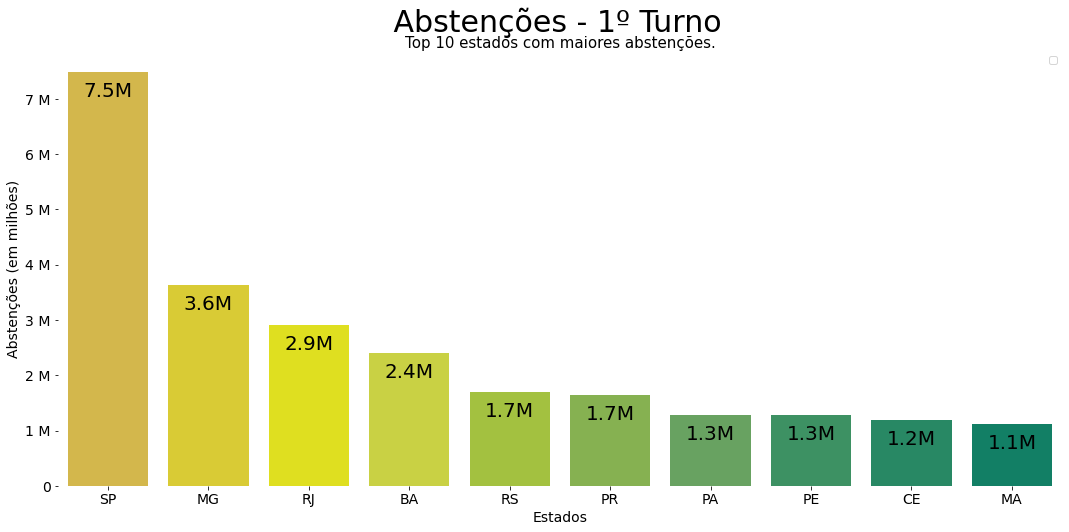

In [26]:
# Montando o setup e plotando o gráfico
cores = ["#eac435","#f4e21a","#ffff00","#dee92c","#afd62b","#87c141","#5fad56","#2f9f62","#189868","#00916e"]

fig = plt.figure(figsize=(18,8))
plot = sns.barplot(x=eixo_x,y=eixo_y, palette=cores)
plt.gcf().text(.5, .93, "   Abstenções - 1º Turno", fontsize = 30, color='Black' ,ha='center', va='center')
plt.title("Top 10 estados com maiores abstenções.", fontsize = 15, ha='center', va='center')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Estados", size = 14)
plt.ylabel("Abstenções (em milhões)", size = 14)

plot.legend(bbox_to_anchor=(1, 1), ncol=1)
plot.set_frame_on(False)
# plot.set(ylim = (50000,250000))                      não usei porque não quero colocar nenhum limite
plot.yaxis.set_major_formatter(ticker.EngFormatter())

for i in plot.patches:
    plot.annotate("{:.1f}M".format(i.get_height()/1000000),
                  (i.get_x() + i.get_width() / 2, i.get_height()),
                  ha='center', va='top', fontsize='20',
                  color='black', xytext=(0,-10),
                  textcoords='offset points')          
plt.show()

In [27]:
agrupado_sp = agrupado_UF[agrupado_UF['SG_UF'] == 'SP']
BR_sem_SP = agrupado_UF[~((agrupado_UF['SG_UF'] == "SP"))]
agrupado_sem_SP = BR_sem_SP.groupby(['SG_UF'], as_index=False)['QT_ABSTENCAO'].sum().sort_values(by='QT_ABSTENCAO',  ascending=False)


In [28]:
agrupado_sp_perc = (agrupado_sp['QT_ABSTENCAO'].sum() / agrupado_UF['QT_ABSTENCAO'].sum())*100
sp_abstencao = agrupado_sp['QT_ABSTENCAO'].sum()
agrupado_br_perc = (agrupado_sem_SP['QT_ABSTENCAO'].sum() / agrupado_UF['QT_ABSTENCAO'].sum())*100
br_abstencao = agrupado_sem_SP['QT_ABSTENCAO'].sum()
print(f'##### São Paulo teve um total de {sp_abstencao:.0f} ({agrupado_sp_perc:.0f}%) das abstenções totais do país no 1º turno.')
print(f'##### O restante do Brasil teve um total de {br_abstencao:.0f} ({agrupado_br_perc:.0f}%) das abstenções totais do país no 1º turno.')


##### São Paulo teve um total de 7494578 (23%) das abstenções totais do país no 1º turno.
##### O restante do Brasil teve um total de 25222162 (77%) das abstenções totais do país no 1º turno.


In [29]:
agrupado_UF.loc[(agrupado_UF['SG_UF'] == 'SP') | (agrupado_UF['SG_UF'] == 'MG') | (agrupado_UF['SG_UF'] == 'RJ')]
br_sem_sp_mg_rj = agrupado_UF[~((agrupado_UF['SG_UF'] == 'SP') | (agrupado_UF['SG_UF'] == 'MG') | (agrupado_UF['SG_UF'] == 'RJ'))]
br_sem_ba_pr_rs = agrupado_UF[~((agrupado_UF['SG_UF'] == 'BA') | (agrupado_UF['SG_UF'] == 'PR') | (agrupado_UF['SG_UF'] == 'RS'))]
agrupado_UF

,SG_UF,QT_ABSTENCAO,perc
25,SP,7494578,0.229075
10,MG,3628828,0.110917
18,RJ,2917151,0.089164
4,BA,2408747,0.073624
22,RS,1699679,0.051951
17,PR,1651443,0.050477
13,PA,1290193,0.039435
15,PE,1277313,0.039042
5,CE,1190120,0.036376
9,MA,1119043,0.034204


In [30]:
sp_br = [agrupado_UF['perc'][25],agrupado_UF['perc'][10],agrupado_UF['perc'][18], br_sem_sp_mg_rj['perc'].sum()]
ba_rs_pr = [agrupado_UF['perc'][4],agrupado_UF['perc'][22],agrupado_UF['perc'][17], br_sem_ba_pr_rs['perc'].sum()]
legenda_sp = ['São Paulo','Minas Gerais','Rio de Janeiro','Outros estados']
legenda_ba = ['Bahia','Rio Grande do Sul','Paraná','Outros estados'] 

explodir = [0.2, 0, 0, 0]
explodir_gf2 = [0.2, 0.2, 0.2, 0]

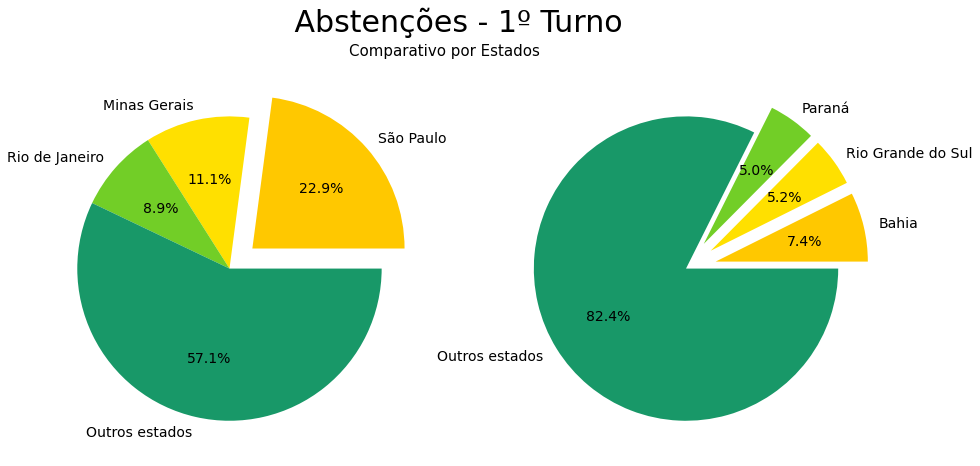

In [31]:
figura = plt.figure(figsize=(15,20))

figura.add_subplot(2,2,1)
plt.pie(sp_br, 
        labels = legenda_sp, 
        explode = explodir,
        autopct='%1.1f%%', 
        textprops={'fontsize': 14},
        colors=["#ffc800", "#FFE000", "#72CE27","#189868"])
figura.add_subplot(2,2,2)

plt.pie(ba_rs_pr, 
        labels = legenda_ba, 
        explode = explodir_gf2,
        autopct='%1.1f%%', 
        textprops={'fontsize': 14},
        colors=["#ffc800", "#FFE000", "#72CE27","#189868"])

plt.gcf().text(.5, .88, "   Abstenções - 1º Turno", fontsize = 30, color='Black' ,ha='center', va='center')
plt.gcf().text(.5, .86, "Comparativo por Estados", fontsize = 15, color='Black' ,ha='center', va='center')
plt.show()

#### Representatividade
>É possível notar que São Paulo e Minas Gerais representam um total de 34% das abstenções totais do país inteiro. Dos **32.716.740** eleitores que se abstiveram no 1º turno em 2022, **11.123.406 (34%)** são desses dois estados apenas.
> Dos outros 26 locais de votação, temos os outros 66% dos eleitores que se abstiveram.

# CONCLUSÃO

> Entendemos que o papel dos faltosos, representando mais de 20% dos eleitores aptos a votar, tem significativo impacto na decisão dos governantes brasileiros.

> Estamos aguardando os dados do segundo turno para fazer um comparativo entre os pleitos.